In [20]:
import numpy as np
import matplotlib.pyplot as plt
import struct
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.metrics import accuracy_score
import time
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
def read_file(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [107]:
# Load Dataset
train_images_file = 'archive/train-images.idx3-ubyte'
train_labels_file = 'archive/train-labels.idx1-ubyte'
test_images_file = 'archive/t10k-images.idx3-ubyte'
test_labels_file = 'archive/t10k-labels.idx1-ubyte'

train_images = read_file(train_images_file)
train_labels = read_file(train_labels_file)
test_images = read_file(test_images_file)
test_labels = read_file(test_labels_file)

In [44]:
# Random Prototype Selection
def Random_prototypes(X, y, M):
    indices = np.random.choice(len(X), size=M, replace=False)
    return X[indices], y[indices]

In [85]:
# K means Prototype Selection
def Kmeans_prototypes(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=None, n_init='auto').fit(X)
    prototypes = kmeans.cluster_centers_
    return prototypes
    
def Assign_centroids(X, y, centroids):
    kmeans = KMeans(n_clusters=len(centroids), init=centroids, n_init=1, max_iter=1)
    kmeans.fit(X)
    labels = np.zeros(len(centroids))

    for i in range(len(centroids)):
        labels[i] = np.argmax(np.bincount(y[kmeans.labels_ == i]))

    return labels

In [91]:
# CNN Prototype Selection
def CNN_prototypes(X, y, M):
    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    prototypes = [X_shuffled[0]]
    labels = [y_shuffled[0]]
    nn = NearestNeighbors(n_neighbors=1)

    for i in range(1, M):
        nn.fit(prototypes, labels)
        nearest = nn.kneighbors([X_shuffled[i]], 1, return_distance=False)
        nearest_label = labels[nearest[0][0]]
        if y_shuffled[i] != nearest_label:
            prototypes.append(X_shuffled[i])
            labels.append(y_shuffled[i])

    return np.array(prototypes), np.array(labels)

In [92]:
# Evaluate Test Error
def Evaluate_test_error(prototypes, prototype_labels, X_test, y_test):
    knn = KNeighborsClassifier()
    knn.fit(prototypes, prototype_labels)
    y_pred = knn.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    return test_error

In [96]:
prototype_sizes = [100, 500, 1000, 5000, 10000]
methods = ['Random', 'K-Means', 'CNN']
results = {}
runtime_results = {}
num_experiments = 5
error_results = {method: {size: [] for size in prototype_sizes} for method in methods}

In [97]:
for size in prototype_sizes:
    for method in methods:
        for e in range(num_experiments):
            start_time = time.time()
            if method == 'Random':
                prototypes, labels = Random_prototypes(train_images.reshape(-1, 784), train_labels, size)
            elif method == 'K-Means':
                prototypes = Kmeans_prototypes(train_images.reshape(-1, 784), size)
                labels = Assign_centroids(train_images.reshape(-1, 784), train_labels, prototypes)
            elif method == 'CNN':
                prototypes, labels = CNN_prototypes(train_images.reshape(-1, 784), train_labels, size)
    
            test_error = Evaluate_test_error(prototypes, labels, test_images.reshape(-1, 784), test_labels)
            error_results[method][size].append(test_error)
            # results[(method, size)] = test_error
            end_time = time.time()
            runtime = end_time - start_time
            runtime_results[(method, size)] = runtime
            print(e,method,size,test_error)

avg_errors = {method: [] for method in methods}
std_errors = {method: [] for method in methods}
for method in methods:
    for size in prototype_sizes:
        m = np.mean(error_results[method][size])
        s = np.std(error_results[method][size])
        avg_errors[method].append(m)
        std_errors[method].append(s)
        results[method, size] = m
results

0 Random 100 0.38060000000000005
1 Random 100 0.356
2 Random 100 0.35219999999999996
3 Random 100 0.3649
4 Random 100 0.3487
0 K-Means 100 0.17930000000000001
1 K-Means 100 0.16090000000000004
2 K-Means 100 0.17979999999999996
3 K-Means 100 0.1744
4 K-Means 100 0.17500000000000004
0 CNN 100 0.4467
1 CNN 100 0.48340000000000005
2 CNN 100 0.48240000000000005
3 CNN 100 0.4619
4 CNN 100 0.3971
0 Random 500 0.16559999999999997
1 Random 500 0.15610000000000002
2 Random 500 0.1693
3 Random 500 0.1735
4 Random 500 0.16300000000000003
0 K-Means 500 0.07620000000000005
1 K-Means 500 0.07450000000000001
2 K-Means 500 0.08079999999999998
3 K-Means 500 0.07609999999999995
4 K-Means 500 0.0736
0 CNN 500 0.269
1 CNN 500 0.26049999999999995
2 CNN 500 0.24229999999999996
3 CNN 500 0.2741
4 CNN 500 0.30479999999999996
0 Random 1000 0.12239999999999995
1 Random 1000 0.12039999999999995
2 Random 1000 0.11970000000000003
3 Random 1000 0.12350000000000005
4 Random 1000 0.12670000000000003
0 K-Means 1000 0.0

{('Random', 100): 0.36048,
 ('Random', 500): 0.1655,
 ('Random', 1000): 0.12254000000000001,
 ('Random', 5000): 0.06507999999999999,
 ('Random', 10000): 0.05182,
 ('K-Means', 100): 0.17388,
 ('K-Means', 500): 0.07624,
 ('K-Means', 1000): 0.06028,
 ('K-Means', 5000): 0.03929999999999998,
 ('K-Means', 10000): 0.03516000000000001,
 ('CNN', 100): 0.45430000000000004,
 ('CNN', 500): 0.27014,
 ('CNN', 1000): 0.19096,
 ('CNN', 5000): 0.10173999999999998,
 ('CNN', 10000): 0.08026}

In [108]:
std_errors

{'Random': [0.011417074931872898,
  0.005883196410115837,
  0.002485638750904904,
  0.00184434270134376,
  0.0016351146748775987],
 'K-Means': [0.00684730603960417,
  0.0024824181758922015,
  0.0015302287410710635,
  0.0008461678320522354,
  0.0016181470884934809],
 'CNN': [0.03169788636486668,
  0.02042690382804012,
  0.010619340845834071,
  0.005289461220200037,
  0.0027118997031601155]}

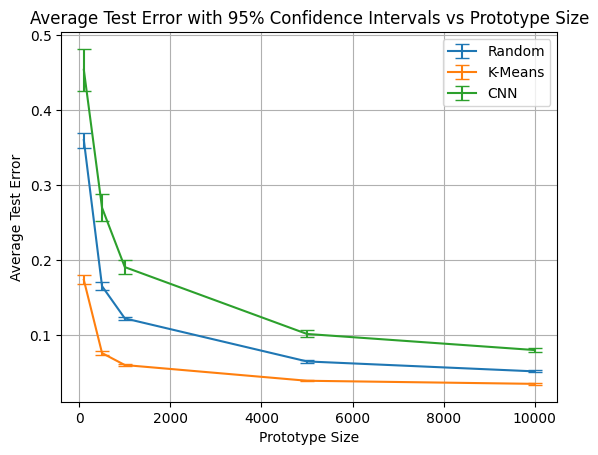

In [105]:
# Plot Test Error with Confidence Intervals
confidence = 0.95
z_score = norm.ppf(1 - (1 - confidence) / 2)  # Z-score for 95% confidence

ci_errors = {method: [] for method in methods}

for method in methods:
    for size in prototype_sizes:
        sample_mean = np.mean(error_results[method][size])
        sample_std = np.std(error_results[method][size])
        margin_error = z_score * (sample_std / np.sqrt(num_experiments))
        ci_errors[method].append(margin_error)
for method in methods:
    avg_error = [np.mean(error_results[method][size]) for size in prototype_sizes]
    ci_error = ci_errors[method]
    plt.errorbar(prototype_sizes, avg_error, yerr=ci_error, label=method, capsize=5)

plt.xlabel('Prototype Size')
plt.ylabel('Average Test Error')
plt.title('Average Test Error with 95% Confidence Intervals vs Prototype Size')
plt.legend()
plt.grid(True)

plt.savefig('AverageTestError95ConfidenceIntervals.png', format='png', dpi=300)
plt.show()

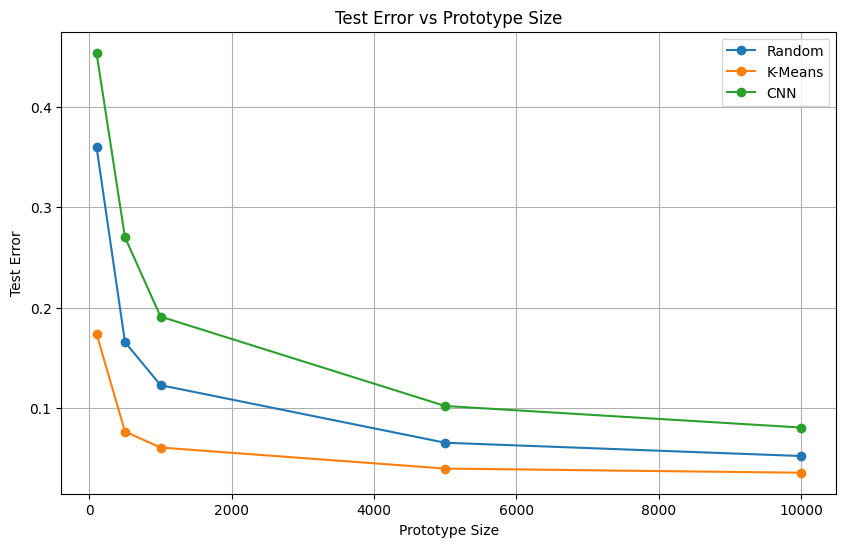

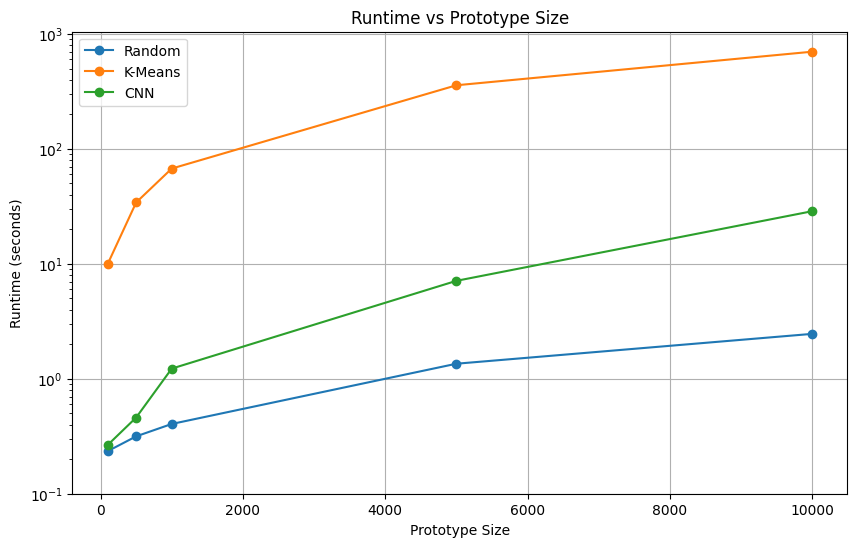

In [106]:
# Plot Test Error
plt.figure(figsize=(10, 6))

for method in methods:
    sizes = []
    errors = []
    for size in prototype_sizes:
        sizes.append(size)
        errors.append(results[(method, size)])
    plt.plot(sizes, errors, marker='o', label=method)

plt.xlabel('Prototype Size')
plt.ylabel('Test Error')
plt.title('Test Error vs Prototype Size')
plt.legend()
plt.grid(True)
plt.savefig('TestError.png', format='png', dpi=300)
plt.show()

# Plot Runtime
plt.figure(figsize=(10, 6))

for method in methods:
    sizes = []
    runtimes = []
    for size in prototype_sizes:
        sizes.append(size)
        runtimes.append(runtime_results[(method, size)])
    plt.plot(sizes, runtimes, marker='o', label=method)

plt.xlabel('Prototype Size')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime vs Prototype Size')
plt.yscale('log')  
plt.ylim(ymin=0.1)  
plt.legend()
plt.grid(True)
plt.savefig('Runtime.png', format='png', dpi=300)
plt.show()